# Install

In [1]:
#@title Download EG3D
!nvidia-smi
!git clone https://github.com/NVlabs/eg3d

Sun Jul 24 18:00:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Download model weights
model_url = "https://api.ngc.nvidia.com/v2/models/nvidia/research/eg3d/versions/1/files/ffhq512-128.pkl"  #@param {type: "string"}
!wget -c $model_url -O model.pkl

--2022-07-24 18:00:22--  https://api.ngc.nvidia.com/v2/models/nvidia/research/eg3d/versions/1/files/ffhq512-128.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.213.148.69, 44.242.42.65
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.213.148.69|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/team/research/models/eg3d/versions/1/files/ffhq512-128.pkl?response-content-disposition=attachment%3B%20filename%3D%22ffhq512-128.pkl%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEEoaCXVzLXdlc3QtMiJGMEQCIHt%2FULhqSeFFpwVtnGA%2FwA5os%2Fw6JNLu56fO6rvzx6smAiBPEQWv%2F81g7g9ZrrRsLuQw2oO34XE0tfpvJoNZxqoC4CrbBAiT%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F8BEAQaDDc4OTM2MzEzNTAyNyIMBzBPXb7EOdD%2BzhllKq8Eq%2BIKukxULwXv3hAxEFY%2BB9kMR5qdMBYxakEotPYLDGEUW6GSX3cZMI6aaJtvXn7fqtKLJ0zkJ3HXQIh9ZjwDxN7ldBHuLki5hsSPcw0ZesfqtR9ctJ1TRyt%2BAn5bQJn%2FZZPgaNe5HfarYhfGEi6

In [3]:
!sudo apt install ninja-build

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 93.3 kB of archives.
After this operation, 296 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 ninja-build amd64 1.8.2-1 [93.3 kB]
Fetched 93.3 kB in 1s (171 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-

In [4]:
!pip install scikit-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [5]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [6]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 652 kB 5.0 MB/s 


# Import

In [7]:
import sys
if "./eg3d/eg3d" not in sys.path:
    sys.path.append("./eg3d/eg3d")

In [8]:
from torch_utils import custom_ops
custom_ops.verbosity = "full"

In [9]:
import numpy as np
import pickle
import torch


device = torch.device("cuda")  # TODO
with open("model.pkl", "rb") as f:
    G = pickle.load(f)["G_ema"].cuda()  # torch.nn.Module

# Run

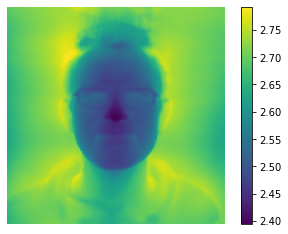

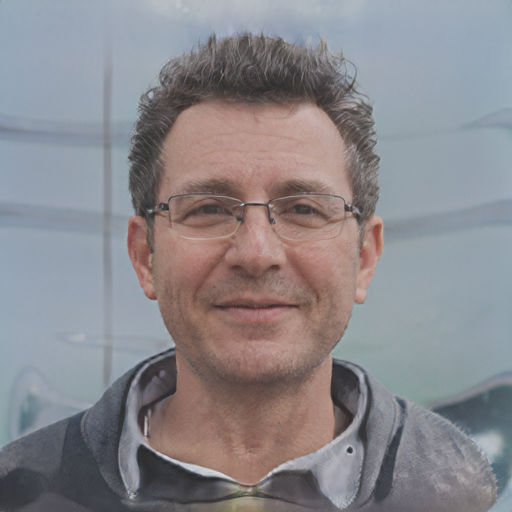

In [18]:
#@title Example: generate random image
from matplotlib import pyplot as plt
from PIL import Image


c = torch.cat((torch.tensor([
                                [-1, 0,  0,  0],
                                [0,  -1, 0,  0],
                                [0,  0,  -1, 2.7],
                                [0,  0,  0,  1]
]).flatten(), torch.tensor([
                                        [3, 0, 0.5],
                                        [0, 3, 0.5],
                                        [0, 0, 5]
]).flatten()))  # TODO
#@markdown Psi truncation (0-1)
psi = 0.5  #@param {type: "number"}
def generate(z, c=c, device=device, psi=psi):
    return G(z, c.to(device).unsqueeze(0).repeat(z.shape[0], 1),
             truncation_psi=psi)


def weights(z, c=c, device=device):
    planes = G.backbone(z,
                        c.unsqueeze(0).to(device).repeat(z.shape[0], 1)
                        )[0][[34, 52]]  # TODO make batched
    planes -= planes.min(dim=1)[0].min(dim=1)[0].unsqueeze(-1).unsqueeze(-1)
    planes /= planes.max(dim=1)[0].max(dim=1)[0].unsqueeze(-1).unsqueeze(-1)
    return planes[0] * 0.8 + planes[1] * 0.2


def to_img(img, as_torch=False, as_numpy=False):
    img = img["image"][0].permute(1, 2, 0) / 3 + 0.5
    if as_torch:
        return img
    img = img.detach().cpu().numpy()
    if as_numpy:
        return img
    return Image.fromarray((np.clip(img, 0, 1) * 255).astype(np.uint8))


z_random = torch.randn([1, G.z_dim]).cuda()
img = generate(z_random)
plt.axis("off")
plt.imshow(img["image_depth"].detach().cpu().numpy()[0, 0])
plt.colorbar()
plt.show()
to_img(img)

Upload image:


Saving generated_image.png to generated_image.png


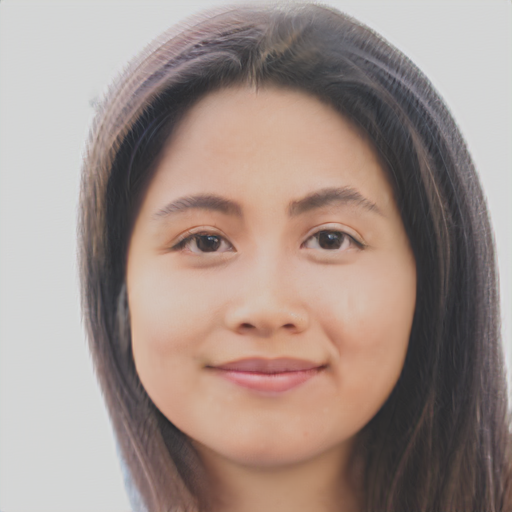

In [11]:
#@title Invert your own image
from PIL import Image
import requests
import io
import os


download = lambda x: Image.open(io.BytesIO(requests.get(x).content))
#@markdown Image URL. Leave empty if you upload your own
url = "" #@param ["https://thispersondoesnotexist.com/image", ""] {allow-input: true}
#@markdown (Optional) image path if you upload your own
path = "face_image.png"  #@param {type: "string"}
if len(url):
    target = download(url)
else:
    if not os.path.exists(path):
        from google.colab import files
        print("Upload image:")
        uploaded = list(files.upload())
        if uploaded:
            path = uploaded[0]
        else:
            print("Please upload something. Erroring out soon...")
    target = Image.open(path)
target = torch.from_numpy(np.asarray(target.convert("RGB").resize(
    (512, 512))) / 255).to(device)
Image.fromarray((target.detach().cpu().numpy() * 255).astype(np.uint8))

In [52]:
from IPython.display import display, clear_output
from tqdm.auto import tqdm, trange
from ipywidgets import Output
import camera_utils
import lpips
import os


#@markdown ## Geometry
#@markdown Default camera focal length (tune to match your camera's zoom, 3-6
#@markdown are good values)
focal_length =   4#@param {type: "number"}
focal_length = torch.nn.Parameter(torch.tensor([focal_length],
                                               dtype=torch.float32,
                                               device=device))
#@markdown Default offset (don't go below 2.8, you'll get body horror)
start_z = 3.2  #@param {type: "number"}
try:
    position
except NameError:
    position = torch.nn.Parameter(
        torch.tensor([0, 0, start_z], dtype=torch.float32, device=device))
try:
    rotation
except NameError:
    rotation = torch.nn.Parameter(
        torch.tensor([0, 0, 0], dtype=torch.float32, device=device))
#@markdown ## Init
#@markdown Random seed, 0 for no seed
seed =   25#@param {type: "integer"}
if seed == 0:
    import random
    seed = random.getrandbits(16)
print("Seed:", seed)
torch.manual_seed(seed)
#@markdown How much to scale down the intialisation by (more conservative)
init_scale = 0.9  #@param {type: "number"}
#@markdown Start from a new face latent instead of reusing (turn off if you
#@markdown know what you're doing)
generate_new = True  #@param {type: "boolean"}
try:
    z
    if generate_new:
        abracadabra  # What if someone makes a variable with that name?
except NameError:
    try:
        z_random
        if generate_new:
            abracadabra
    except NameError:
        z_random = torch.randn([1, G.z_dim], dtype=torch.float32, device=device)
    z = torch.nn.Parameter(z_random[0] * init_scale)


# It would be shorter to just hardcode
def rotation_matrix(angle, dim=0):
    s = angle.sin()
    c = angle.cos()
    dims = [d for d in range(3) if d != dim]
    return torch.zeros(9).to(angle).index_add(
        0,
        torch.LongTensor([dims[0] + dims[0] * 3,
                          dims[1] + dims[0] * 3,
                          dims[0] + dims[1] * 3,
                          dims[1] + dims[1] * 3, dim + dim * 3
                          ]).to(angle.device), torch.cat([c, s, -s, c,
                                                          angle * 0 + 1
                                                          ])).reshape(3, 3)


def rotate(euler):
    return (
        rotation_matrix(euler[0:1], 0)
        @ rotation_matrix(euler[1:2], 1)
        @ rotation_matrix(euler[2:3], 2))


def get_cam_matrix():
    return torch.tensor(
        [
            [0, 0, 0.5],
            [0, 0, 0.5],
            [0, 0, 1]
        ], dtype=torch.float32, device=device).flatten().index_add(
            0,
            torch.LongTensor([0, 4]).to(device),
            torch.cat((focal_length,) * 2)).reshape(3, 3)


def make_c():
    matrix = torch.tensor([
                        [-1, 0,  0],
                        [0, -1,  0],
                        [0,  0, -1]
    ]).float().to(device)
    matrix = matrix @ rotate(rotation)
    # Position is not rotated
    pos = torch.maximum(torch.tensor([-10, -10, 2.6]).to(position),
                        position)
    matrix = torch.cat((matrix, pos.unsqueeze(-1)), dim=1)
    matrix = torch.cat((matrix, torch.eye(4)[-1:].to(device)), dim=0)
    cam_matrix = get_cam_matrix().flatten()
    return torch.cat((matrix.flatten(), cam_matrix)).float().to(device)


def render():
    return generate(z.unsqueeze(0), make_c()), weights(z.unsqueeze(0), make_c())


#@markdown ## Training
#@markdown Number of training interations
iterations =   1000  #@param {type: "integer"}
#@markdown Iterations in the end to just fly around
show_iterations = 200  #@param {type: "integer"}
#@markdown Display images every N training steps (make this higher if you see
#@markdown flickering or the notebook slows down)
show_every = 1  #@param {type: "integer"}
#@markdown Save every N steps
save_every = 60  #@param {type: "integer"}
#@markdown Save to this file
save_to = "EG3D.pt"  #@param {type: "string"}
#@markdown Master learning rate
lr =   0.4  #@param {type: "number"}
#@markdown Position, rotation and focal length learning rate
p_lr = 4e-2  #@param {type: "number"}
#@markdown Generator latent learning rate
z_lr = 2e-1  #@param {type: "number"}
#@markdown PTI learning rate
g_lr = 0.0  #@param {type: "number"}
#@,arldpwm Gradient clipping norm
clip_grad_norm = 10.0  #@param {type: "number"}
#@markdown How much to take position into account for loss (experimental)
weight_weight = 0.0  #@param {type: "number"}
#@markdown Loss weight for L2 regularization on latents
reg_weight = 0.01  #@param {type: "number"}
#@markdown Network to be used for LPIPS
lpips_net = "vgg"  #@param {type: "string"} ["vgg", "alex"]
#@markdown LPIPS loss weight
perceptual_weight = 0.2  #@param {type: "number"}
# TODO: add face landmark alignment loss

perceptual_loss = lpips.LPIPS(net=lpips_net).to(device)
optim = torch.optim.Adam([{"params": [position, rotation, focal_length],
                           "lr": p_lr * lr},
                          {"params": [z], "lr": z_lr * lr},
                          {"params": G.parameters(), "lr": g_lr * lr}])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, iterations,
                                                       eta_min=1e-4)
out = Output()
display(out)
frames = []
try:
    with trange((iterations + show_iterations)) as bar:
        for i in bar:
            pic, weight = render()
            im = to_img(pic, as_torch=True)
            losses = ((im - target) ** 2).mean(dim=-1)
            weight = torch.nn.functional.interpolate(
                weight.unsqueeze(0).unsqueeze(0), (im.shape[0], im.shape[1]))[0, 0]
            weight = weight * weight_weight + (1 - weight_weight)
            mse = (losses * weight.detach()).mean()
            reg = torch.norm(z)
            perceptual = perceptual_loss(
                im.unsqueeze(0).permute(0, 3, 1, 2) * 2 - 1,
                target.unsqueeze(0).permute(0, 3, 1, 2).float() * 2 - 1)
            loss = (
                mse
                + reg * reg_weight
                + perceptual * perceptual_weight)
            bar.set_postfix(loss=loss.item(), mse=mse.item(), reg=reg.item(),
                            perceptual=perceptual.item())
            if i < iterations:
                loss.backward()
                for group in optim.param_groups:
                    torch.nn.utils.clip_grad_norm_(group["params"], clip_grad_norm)
                optim.step()
                optim.zero_grad()
                scheduler.step()
            frame = to_img(pic)
            angle = i / 10
            angled_c = camera_utils.LookAtPoseSampler().sample(
                np.sin(angle) / 2 + np.pi / 2,
                np.cos(np.sin(angle / 2) / 2) / 2 * np.pi,
                torch.zeros(3), radius=start_z)
            pic2 = generate(z.unsqueeze(0),
                            torch.cat((angled_c.flatten().to(device),
                                    get_cam_matrix().flatten())).float().to(
                                        device))
            depth = torch.nn.functional.interpolate(pic2["image_depth"], im.shape[:2]
                                            )[0, 0].cpu().detach().numpy()
            depth -= depth.min()
            depth *= depth.max()
            depth = np.tile((depth[:, :, np.newaxis] * 255).astype(np.uint8),
                            (1, 1, 3))
            frame = Image.fromarray(np.concatenate((
                np.concatenate((
                    np.asarray(frame),
                    depth
                ), axis=0),
                np.concatenate((
                    (np.asarray(target.detach().cpu().numpy())
                    * 255).astype(np.uint8), np.asarray(to_img(pic2))
                ), axis=0)
            ), axis=1))
            frames.append(frame)
            if i % show_every == show_every - 1:
                with out:
                    clear_output(wait=True)
                    display(frame)
            if i % save_every == save_every - 1:
                torch.save((z, (position, rotation, focal_length)), save_to)
except KeyboardInterrupt:
    print("Early exit")

Seed: 25
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


Output()

  0%|          | 0/1200 [00:00<?, ?it/s]

Early exit



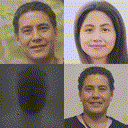

In [53]:
#@title Save optimization video
from IPython.display import display, HTML
from skvideo.io import FFmpegWriter
from base64 import b64encode


def save_gif(frames, out_path="video.mp4", display=False):
    if display:
        tq = tqdm
    else:
        tq = lambda x: x
    writer = FFmpegWriter(out_path)
    for frame in tq(frames):
        writer.writeFrame(np.asarray(frame))
        if display:
            from IPython.display import display as show
            show(frame)
    writer.close()


resolution = 128  #@param {type: "integer"}
out_path = "video.gif"  #@param {type: "string"}
save_gif([f.resize((resolution, resolution)) for f in frames], out_path)
video = open(out_path, "rb").read()
data_url = f"data:image/gif;base64," + b64encode(video).decode()
display(HTML(f"<img src={data_url}>"))

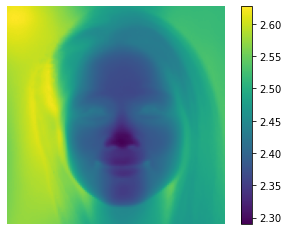

  0%|          | 0/128 [00:00<?, ?it/s]

In [54]:
#@title (Experimental) 3D Export
import trimesh


im = to_img(pic, as_numpy=True)
im = im[::4, ::4]
focus = (1 / focal_length).item()
step = focus / im.shape[0] * 2
rays = np.mgrid[-focus:focus:step,
                -focus:focus:step]
pic = generate(z.unsqueeze(0), make_c())
depth = torch.nn.functional.interpolate(pic["image_depth"], im.shape[:2]
                                        )[0, 0].cpu().detach().numpy()
plt.axis("off")
plt.imshow(depth)
plt.colorbar()
plt.show()
xyz = np.concatenate(((rays * depth).transpose(1, 2, 0),
                      depth[..., np.newaxis]),
                     axis=-1).reshape(-1, 3)
colors = im.reshape(-1, 3)
faces = []
c = lambda x, y: y * im.shape[1] + x
for y in trange(im.shape[0]):
    for x in range(im.shape[1]):
        if x > 0 and y > 0:
            faces.append([c(x, y), c(x, y - 1), c(x - 1, y)])
        if x < im.shape[1] - 1 and y < im.shape[0] - 1:
            faces.append([c(x, y), c(x, y + 1), c(x + 1, y)])
face_colors = np.asarray([colors[i[0]] for i in faces])
texture = Image.fromarray((im * 255).astype(np.uint8))
uv = np.mgrid[0:im.shape[0], 0:im.shape[1]].reshape(2, -1).T
tri_mesh = trimesh.Trimesh(vertices=xyz[..., [1, 0, 2]] * -1,
                           faces=faces,
                           vertex_colors=colors,
                           smooth=True)

In [55]:
#@title Save mesh
from datetime import datetime


#@markdown Name of the file (leave empty to name automatically)
mesh_path = ""  #@param ["", "eg3d.ply"] {type: "string", allow-input: true}
#@markdown Path to save in google drive, leave empty if you want to store it in the Colab session only
drive_path = "EG3D"  #@param ["", "EG3D"] {type: "string", allow-input: true}
if not mesh_path:
    # TODO use hash of source image instead?
    mesh_path = f"e-{datetime.strftime(datetime.now(),'%Y_%m_%d-%H_%M_%S')}.ply"

#@markdown Download the resulting .obj file?
download_mesh = True  #@param {type: "boolean"}
kwargs = dict()  # TODO put something here
tri_mesh.export(mesh_path, **kwargs)

if download_mesh:
    from google.colab import files
    files.download(mesh_path)

if drive_path:
    from google.colab import drive
    print("Mounting drive...")
    drive.mount("/content/drive/")
    print("Saving to drive...")
    drive_path = f"/content/drive/MyDrive/{drive_path}"
    os.makedirs(drive_path, exist_ok=True)
    tri_mesh.export(f"{drive_path}/{mesh_path}", **kwargs)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mounting drive...
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Saving to drive...


# by [@nev#4950](https://twitter.com/apeoffire)